In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ortho_group
import torch 
import torch.nn as nn
import torch.nn.functional as F

In [2]:
def sample_gaussian(mu, var, n):
    return np.random.multivariate_normal(mu, var, n)

In [3]:
def sample_source_and_target_params(min_var, max_var, dim=2):
    mus = []
    vars = []
    for i in range(4):
        mu = np.random.multivariate_normal(np.zeros(dim), np.eye(dim))
        mu = mu / np.linalg.norm(mu)
        mus.append(mu)

        var_diag = np.diag(np.random.uniform(min_var, max_var, dim))
        rot_mat = ortho_group.rvs(dim)
        var = rot_mat.T @ var_diag @ rot_mat
        vars.append(var)
    return np.array(mus), np.array(vars)

In [4]:
def sample_fixed_params(mus, vars, n, p):
    # sample labels 0 and 1 with 1 having probability p
    labels = np.random.binomial(1, p, n)
    # sample from the corresponding gaussian
    ones = sample_gaussian(mus[1], vars[1], n)
    zeros = sample_gaussian(mus[0], vars[0], n)
    samples = np.zeros((n, 2))
    samples[labels == 1] = ones[labels == 1]
    samples[labels == 0] = zeros[labels == 0]
    return torch.tensor(np.array(samples), dtype=torch.float32), torch.tensor(labels, dtype=torch.float32)

In [5]:
def sample_intermediate_params(source_mus, source_vars, target_mus, target_vars, n, b, p):
    # sample labels 0 and 1 with 1 having probability p
    samples = []
    labels = []
    for i in range(n):
        alpha = i / n
        label = np.random.binomial(1, p, b)
        mus = (1 - alpha) * source_mus + alpha * target_mus
        vars = (1 - alpha) * source_vars + alpha * target_vars
        # sample from the corresponding gaussian
        ones = sample_gaussian(mus[1], vars[1], b)
        zeros = sample_gaussian(mus[0], vars[0], b)
        sample = np.zeros((b, 2))
        sample[label == 1] = ones[label == 1]
        sample[label == 0] = zeros[label == 0]
        labels.append(label)
        samples.append(sample)
    return torch.tensor(np.array(samples), dtype=torch.float32), torch.tensor(np.array(labels), dtype=torch.float32)

In [6]:
# create a linear traininable model
class LogisticRegression(nn.Module):
    def __init__(self, dim):
        super(LogisticRegression, self).__init__()
        self.fc = nn.Linear(dim, 1)

    def forward(self, x):
        x = self.fc(x)
        x = F.sigmoid(x)
        return x

In [7]:
def evaluate_model(model, xs, ys):
    model.eval()
    with torch.no_grad():
        pred = model(xs)
        pred = pred.squeeze()
        pred[pred > 0.5] = 1
        pred[pred <= 0.5] = 0
        acc = (pred == ys).sum().item() / ys.size(0)
    return acc

In [96]:
def train_on_source(model, xSourceTrain, ySourceTrain, epochs=1000, lr=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        pred = model(xSourceTrain)
        loss = F.binary_cross_entropy(pred.squeeze(), ySourceTrain)
        loss.backward()
        optimizer.step()
        # if epoch % 100 == 0:
        #     print("Epoch: {}, loss: {}".format(epoch, loss.item()))

In [95]:
def adapt1(model, xs, epochs=1000, lr=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()
    for epoch in range(epochs):
        optimizer.zero_grad()
        yPred = model(xs)
        predLabels = (yPred > 0.5).float()
        loss = criterion(yPred, predLabels.detach())
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print('Epoch {}, loss {}'.format(epoch, loss.item()))

In [ ]:
def adapt2(model, xSource, ySource, xShift, epochs=100, lr=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()
    for epoch in range(epochs):
        optimizer.zero_grad()
        yPredSource = model(xSource)
        yPredShift = model(xShift)
        yPredShiftLabels = (yPredShift > 0.5).float()
        loss = criterion(yPredSource.squeeze(), ySource.detach()) + criterion(yPredShift, yPredShiftLabels.detach())  
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print('Epoch {}, loss {}'.format(epoch, loss.item()))

In [87]:
def plot_decision_boundary(model):
    # obtain meshgrid of points
    x = np.linspace(-2, 2, 200)
    y = np.linspace(-2, 2, 200)
    xx, yy = np.meshgrid(x, y)
    # flatten the meshgrid and stack them together
    xx_flat = xx.flatten()
    yy_flat = yy.flatten()
    xx_flat = torch.tensor(xx_flat, dtype=torch.float32)
    yy_flat = torch.tensor(yy_flat, dtype=torch.float32)
    xy_flat = torch.stack([xx_flat, yy_flat], dim=1)
    # obtain predictions
    model.eval()
    with torch.no_grad():
        pred = model(xy_flat)
        pred = pred.squeeze()
        # keep the points where the probability is between 0.4 and 0.6
        mask = (pred > 0.45) & (pred < 0.55)
        xx_flat = xx_flat[mask]
        yy_flat = yy_flat[mask]
    # plot the points
    plt.scatter(xx_flat, yy_flat, s=0.5, c='r')

In [105]:
np.random.seed(5000)
torch.manual_seed(0)
n, b, p = 100, 100, 0.5
mus, vars = sample_source_and_target_params(0.05, 0.1)
source_means = mus[:2]
source_vars = vars[:2]
target_means = mus[2:]
target_vars = vars[2:]
xSourceTrain, ySourceTrain = sample_fixed_params(source_means, source_vars, 1000, 0.5)
xTargetTrain, yTargetTrain = sample_fixed_params(target_means, target_vars, 1000, 0.5)
xSourceVal, ySourceVal = sample_fixed_params(source_means, source_vars, 100, 0.5)
xTargetVal, yTargetVal = sample_fixed_params(target_means, target_vars, 100, 0.5)
xTargetTest, yTargetTest = sample_fixed_params(target_means, target_vars, 100, 0.5)
xInter, yInter = sample_intermediate_params(source_means, source_vars, target_means, target_vars, n, b, np.linspace(0.5, 0.8, n))

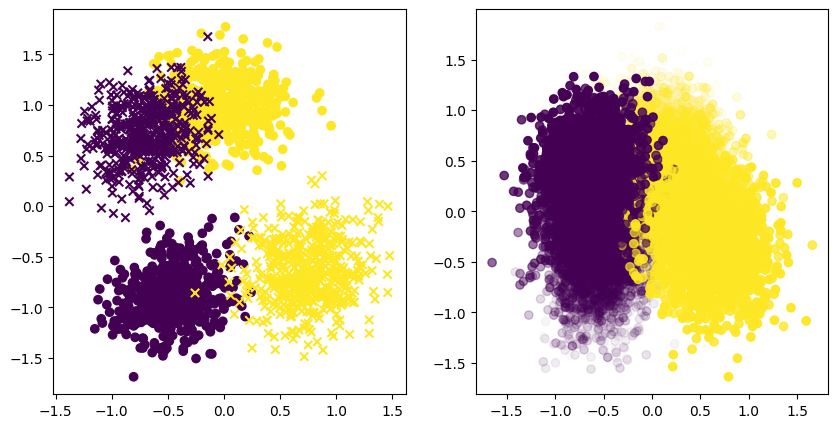

In [106]:
# plot the source and target data with source being circles and target being crosses and the different y having different colors
f, ax = plt.subplots(1, 2)
f.set_figwidth(10)
f.set_figheight(5)
ax[0].scatter(xSourceTrain[:, 0], xSourceTrain[:, 1], c=ySourceTrain, marker='o')
ax[0].scatter(xTargetTrain[:, 0], xTargetTrain[:, 1], c=yTargetTrain, marker='x')
for i in range(n):
    ax[1].scatter(xInter[i][:, 0], xInter[i][:, 1], c=yInter[i], marker='o', alpha=i/n)
plt.show()

In [107]:
model = LogisticRegression(2)
train_on_source(model, xSourceTrain, ySourceTrain)
sourceTrainAcc = evaluate_model(model, xSourceTrain, ySourceTrain)
sourceValAcc = evaluate_model(model, xSourceVal, ySourceVal)
targetTrainAcc = evaluate_model(model, xTargetTrain, yTargetTrain)
targetValAcc = evaluate_model(model, xTargetVal, yTargetVal)
print('Source train acc {}, source val acc {}, target train acc {}, target val acc {}'.format(sourceTrainAcc, sourceValAcc, targetTrainAcc, targetValAcc))

Source train acc 0.998, source val acc 1.0, target train acc 0.232, target val acc 0.29


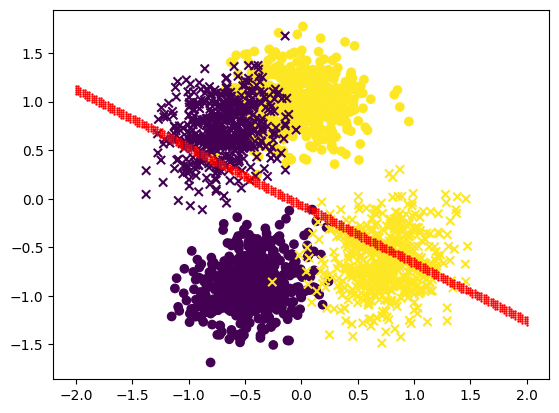

In [108]:
# plot the source and target data with source being circles and target being crosses and the different y having different colors

plt.scatter(xSourceTrain[:, 0], xSourceTrain[:, 1], c=ySourceTrain, marker='o')
plt.scatter(xTargetTrain[:, 0], xTargetTrain[:, 1], c=yTargetTrain, marker='x')
plot_decision_boundary(model)
plt.show()

In [101]:
adapt1(model, xTargetTrain)
sourceTrainAcc = evaluate_model(model, xSourceTrain, ySourceTrain)
sourceValAcc = evaluate_model(model, xSourceVal, ySourceVal)
targetTrainAcc = evaluate_model(model, xTargetTrain, yTargetTrain)
targetValAcc = evaluate_model(model, xTargetVal, yTargetVal)
print('Source train acc {}, source val acc {}, target train acc {}, target val acc {}'.format(sourceTrainAcc, sourceValAcc, targetTrainAcc, targetValAcc))

Epoch 0, loss 0.2675148844718933
Epoch 100, loss 0.154576376080513
Epoch 200, loss 0.07980287075042725
Epoch 300, loss 0.04665498435497284
Epoch 400, loss 0.031180541962385178
Epoch 500, loss 0.023291822522878647
Epoch 600, loss 0.018264632672071457
Epoch 700, loss 0.014880162663757801
Epoch 800, loss 0.012253292836248875
Epoch 900, loss 0.01006880309432745
Source train acc 1.0, source val acc 1.0, target train acc 0.0, target val acc 0.0


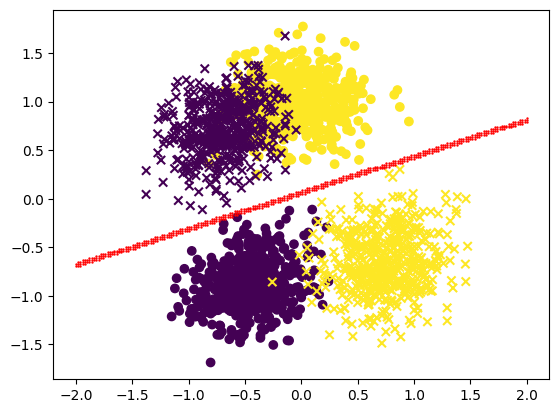

In [102]:
plt.scatter(xSourceTrain[:, 0], xSourceTrain[:, 1], c=ySourceTrain, marker='o')
plt.scatter(xTargetTrain[:, 0], xTargetTrain[:, 1], c=yTargetTrain, marker='x')
plot_decision_boundary(model)
plt.show()

In [109]:
for i in range(n):
    print("****************** INTER",i,"****************")
    xInterTrain, yInterTrain = xInter[i], yInter[i]
    adapt(model, xInterTrain)
    sourceTrainAcc = evaluate_model(model, xSourceTrain, ySourceTrain)
    sourceValAcc = evaluate_model(model, xSourceVal, ySourceVal)
    targetTrainAcc = evaluate_model(model, xTargetTrain, yTargetTrain)
    targetValAcc = evaluate_model(model, xTargetVal, yTargetVal)
    print('Source train acc {}, source val acc {}, target train acc {}, target val acc {}'.format(sourceTrainAcc, sourceValAcc, targetTrainAcc, targetValAcc))

****************** INTER 0 ****************
Epoch 0, loss 0.0343940295279026
Epoch 100, loss 0.0214137714356184
Epoch 200, loss 0.015637099742889404
Epoch 300, loss 0.01237558014690876
Epoch 400, loss 0.010278447531163692
Epoch 500, loss 0.008811146952211857
Epoch 600, loss 0.007721966598182917
Epoch 700, loss 0.006877412088215351
Epoch 800, loss 0.006200303323566914
Epoch 900, loss 0.005642985925078392
Source train acc 1.0, source val acc 1.0, target train acc 0.069, target val acc 0.06
****************** INTER 1 ****************
Epoch 0, loss 0.0023326552473008633
Epoch 100, loss 0.0012368980096653104
Epoch 200, loss 0.0008514009532518685
Epoch 300, loss 0.0006341647822409868
Epoch 400, loss 0.0004947329871356487
Epoch 500, loss 0.0003985463408753276
Epoch 600, loss 0.0003288502339273691
Epoch 700, loss 0.00027647733804769814
Epoch 800, loss 0.00023596579558216035
Epoch 900, loss 0.00020389769633766264
Source train acc 1.0, source val acc 1.0, target train acc 0.134, target val acc 0

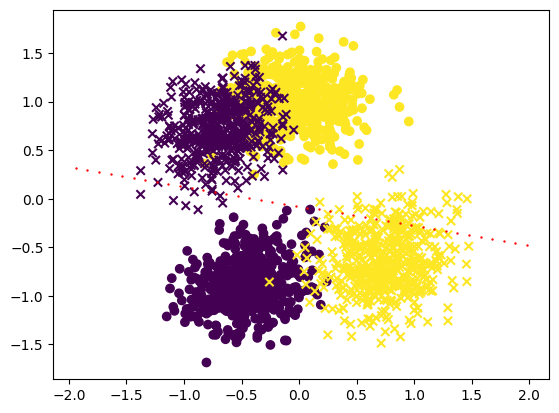

In [110]:
# plot the source and target data with source being circles and target being crosses and the different y having different colors

plt.scatter(xSourceTrain[:, 0], xSourceTrain[:, 1], c=ySourceTrain, marker='o')
plt.scatter(xTargetTrain[:, 0], xTargetTrain[:, 1], c=yTargetTrain, marker='x')
plot_decision_boundary(model)
plt.show()

In [ ]:
adapt2(model, xSourceTrain, ySourceTrain, xTargetTrain)
sourceTrainAcc = evaluate_model(model, xSourceTrain, ySourceTrain)
sourceValAcc = evaluate_model(model, xSourceVal, ySourceVal)
targetTrainAcc = evaluate_model(model, xTargetTrain, yTargetTrain)
targetValAcc = evaluate_model(model, xTargetVal, yTargetVal)
print('Source train acc {}, source val acc {}, target train acc {}, target val acc {}'.format(sourceTrainAcc, sourceValAcc, targetTrainAcc, targetValAcc))